# **[:+:] -- Feature Selection + Nearest Neighbor -- [:+:]**

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
#import seaborn as seab
from itertools import chain, combinations
#from scipy.spatial import minkowski_distance
from numba import jit, cuda
from timeit import default_timer as timer
from math import comb
# from itertools import combinations

# [:::] --- TodDo  ---
# - [x] Find "default Rate" : size(most common class)/size(dataset)
# - [x] Create Minkowski Distance function for two points
# - [x] Find nn of a single data point using only one feature
# - [x] Get rid of spurrious percision
# - [x] For small data, find nn of every data point using one feature + max accuracy
# - [x] For small data, find nn of every data point using all features + max accuracy
# - [x] Complete Forward selection for small datas set
# - [x] GPU Multithreading for Classifier
# - [x] Leave-One-Out Cross Validation
# - [x] Complete Backward Elimination for small data set
# - [x] Forward selection methods for large data set
# - [x] Forward Selection validation for both datasets
# - [x] Data Processing funtion
# - [x] Backelimination for large Data
# - [x] Data Viz
# - [x] Report
# - [] User UI
# - [x] Third Feature
# - [] Apend Data Processing function with distance matrix formation
# - [] multithread everything else
# - [] Find more brown m&ms
# - [] Clean up the code

### **[+]** Read and Process Data

In [139]:
#Read data from the text files and set as a pandas data frame
lilData = pd.read_csv('CS170_Small_Data__19.txt', sep="  ", engine='python', header=None)
bigData = pd.read_csv('CS170_Large_Data__3.txt', sep="  ", engine='python', header=None)

print("\nConvert to numpy array to enable multithreading later:")
lilData= lilData.to_numpy()
bigData= bigData.to_numpy()
print("column size after conversion: " + str(len(lilData[0])))
lilData= lilData.transpose()
bigData= bigData.transpose()
print("column size after transposition: " + str(len(lilData[0])))
print("Dimensions after transposition: " + str(lilData.shape))
print(type(lilData[0][0]))


data= lilData
#print all the data:
#print(lilData)


#----print just the 'label' column (and indeces):
# print("The first 4 entries of the first column: data[colIdx][rowIdx]:")
# print(data[0][0:5])
# print(type(data[0][0]))


# print("\nOriginal Matrix Dimensions:")
# lil_rowXcol= data.shape
# print(lil_rowXcol)


# print("Data Head:")
# print(data.head())

# print("MetaData: ")
# lilData.describe()



# print('Occurrence counts of classes:')
# # count occurrences of the class column
# occur = lilData.groupby([0]).size()
# # display occurrences of a particular column
# display(occur)






Convert to numpy array to enable multithreading later:
column size after conversion: 7
column size after transposition: 500
Dimensions after transposition: (7, 500)
<class 'numpy.float64'>


### **[+]** Minkowski Distance Calculation

In [140]:
#My (from-scratch)Function takes in indices of two data points and exponent p, returns the minkowski distance between them based on the four dimensions and the exponent
@jit(target_backend='cuda')
def minkowski(data,rowIdx1,rowIdx2,ftSet,p):
    # featSet1= []
    # featSet2= []
    sigma= 0
    for ft in ftSet:
        # featSet1.append(data[ft][rowIdx1])
        # featSet2.append(data[ft][rowIdx2])
        sigma+= ((((data[ft][rowIdx1]-data[ft][rowIdx2])**2))**(1/2))  **(p)
        distance= sigma**(1/p)
    return distance
    # return distance, featSet1, featSet2

# d= minkowski(lilData, rowIdx1=1, rowIdx2= 2, ftSet=(1,2,3,4,5,6), p=2)
# print(d)
# minkowski_distance(d[1],d[2],p=2)

### **[:+:]** Forward Selection **+** Backward Elimination

In [141]:
# @jit(nopython=False)
def generateFtCombos(data, limit=6):
    # features= np.empty(0)
    # ftCombos= np.empty(0)
    features= np.empty(0).astype(int)
    ftCombos= []
    ftRow= data.shape[0]
    for i in range(1,ftRow):
        features= np.append(features, i)
    for ft in range(1, limit):
        for combo in itertools.combinations(features, ft):
            ftCombos.append(combo)
    return features, (ftCombos)






    

# @jit(target_backend='cuda')
def generateDefaultRate(data):
    classCnt= [0,0]
    for pt in data[0]:
        if pt==1:
            classCnt[0]+= 1
        else:
            classCnt[1]+= 1
    defaultRate= max(classCnt)/(classCnt[0]+classCnt[1])
    return defaultRate


# takes a single combo of features, classifies each dp by its nearest neighbor, returns a list of classifications for every dp
@jit(target_backend='cuda')
def classifier(data, ftSet):
    rows= data.shape[1]
    nearestNeighbors= np.empty(0)
    for dp in range(0,rows):
        nnIdx= 0
        nearest= 10000
        classification= 0
        for  neighborIdx in range(0,rows):
            if dp != neighborIdx:
                dist= minkowski(data, dp, neighborIdx, ftSet, p=2)
                if dist < nearest:
                    nnIdx= neighborIdx
                    nearest= dist
        classification= data[0][nnIdx]
        nearestNeighbors= np.append(nearestNeighbors, classification)
    return nearestNeighbors


#  Returns the accuracy of the classifier tested with a combination of features (leave-one-out, k=n)
# @jit(target_backend='cuda')
def crossValidate(data, ftSet):
    classes= classifier(data, ftSet)
    classesL= len(classes)
    correct= 0
    for j in range(0,classesL):
        if classes[j] == data[0][j]:
            correct+=1
    accuracy = correct/classesL
    return accuracy


# @jit(target_backend='cuda')
def forwardSelection(data, prevFtSet=np.asarray([]),finalAccuracy=0, finalSet=np.asarray([]), globalAccs=[], globalFts=[]):
    ftSetLen= len(prevFtSet)
    ftRowLength= data.shape[0]

    # globalAccs= []
    # globalFts= []

    if ftSetLen>= ftRowLength-1:
        bestFtSet= finalSet
        print("[:+:] ---  Forward Selection Results: The best set of features is " +str(bestFtSet)+ " | Accuracy: %" +str(round(finalAccuracy*100,3))+ "  --- [:+:]")
    else:
        print("[::] -- Forward Selection Search Tree Level "+str(ftSetLen+1)+ " -- [::]" )
        if ftSetLen==0:
            print("        - Testing without features  | Default Rate: %" + str(round(generateDefaultRate(data)*100,3)))
        bestAcc= 0
        bestFtSubset= np.empty(0)
        for ft in range(1, ftRowLength):
            ftSet= np.empty(0)
            if ft not in prevFtSet:
                ftSet= np.append(prevFtSet, ft).astype(int)
                ftAccuracy= crossValidate(data,ftSet)
                print("        - Testing with features "+ str(ftSet) + " | Accuracy: %" + str(round(ftAccuracy*100,3)))
                if ftAccuracy>bestAcc: 
                    bestAcc= ftAccuracy
                    bestFtSubset= ftSet
        if bestAcc>finalAccuracy:
            finalSet= bestFtSubset
            finalAccuracy= bestAcc

        print("     [+] -- On level "+str(ftSetLen+1)+ ", we add feature subset " + str(bestFtSubset)+" with an accuracy of %" + str(round(bestAcc*100,3))+ "\n")
        globalAccs.append(round(bestAcc*100,3))
        globalFts.append(bestFtSubset)
        print(globalAccs)
        print(globalFts)
        bestFtSet=  forwardSelection(data, bestFtSubset,finalAccuracy, finalSet,globalAccs, globalFts)
    return bestFtSet, globalFts, globalAccs



def backwardElimination(data, prevFtSet=np.empty(0), eliminated=np.empty(0), globalAcc=0, globalFts=np.empty(0)):
    ftRowL= data.shape[0]
    if ftRowL<10:
        ftCombos= generateFtCombos(data)[1]
    else:
        # ftSetNew= (generateFeatures(ftRowL))
        # ftCombos= getTriplets(np.asarray(ftSetNew))
        ftCombos= generateFtCombos(data,limit=3)[1]
    
    bestAcc= 0
    bestFts= np.empty(0)
    prevComboL= len(prevFtSet)
    leveL= ftRowL - prevComboL
    elimCandidate= []
    print("[::] -- Backward Elimination Search Tree Level "+str(leveL)+ " -- [::]" )
    if(prevComboL==1):
        defaultRate= generateDefaultRate(data)
        print("After eliminating all features, we  und up with a default rate of: " +str(defaultRate))
        print("\n[:+:] ---  Backward Selection Results: The best set of features is " +str(globalFts)+ " | Accuracy: %" +str(round(globalAcc*100,3))+ "  --- [:+:]")
        return globalFts, globalAcc
    else:
        if(prevComboL==ftRowL-1):
            print("        - Testing with features "+ str(prevFtSet) + " | Accuracy: %" + str(round(crossValidate(data, prevFtSet )*100,3)))
        for i in range(0, len(ftCombos)):
            ftSet= np.empty(0)
            combo= set(ftCombos[i])
            if (len(combo)==(prevComboL-1)):
                commonElmtCnt= len(combo.intersection(eliminated))
                if(commonElmtCnt==0):
                    ftSet= np.append(ftSet, list(combo)).astype(int)
                    ftAccuracy= crossValidate(data, ftSet )
                    print("        - Testing with features "+ str(ftSet) + " | Accuracy: %" + str(round(ftAccuracy*100,3)))
                    if ftAccuracy>bestAcc:
                        bestAcc= ftAccuracy
                        bestFts= ftSet
                        elimCandidate= list(set(prevFtSet).difference((combo)))[0]
        eliminated= np.append(eliminated, elimCandidate).astype(int)
        print("     [-] -- On level "+str(leveL)+ ", we eliminate feature ["+ str(elimCandidate)+"], and end up with feature set: " + str(bestFts)+" with an accuracy of %" + str(round(bestAcc*100,3)))
        print("                                        [:-:] Eliminated so far:--->"+ str(eliminated)+ "\n")
        if bestAcc>globalAcc:
            globalAcc= bestAcc
            globalFts= bestFts
        return backwardElimination(data, bestFts,eliminated, globalAcc, globalFts)



def exhaustiveSelection(data):
    bestAcc= 0
    bestFt= np.empty(0)
    bestTriplet= []
    for combo in generateFtCombos(data)[1]:
        ftSet= np.empty(0)      
        ftSet= np.append(ftSet, combo).astype(int)
        ftAccuracy= crossValidate(data, ftSet )
        print("        - Testing with features "+ str(ftSet) + " | Accuracy: %" + str(round(ftAccuracy*100,3)))
        if ftAccuracy>bestAcc:
            bestAcc= ftAccuracy
            bestFt= ftSet
            if len(ftSet)==3:
                bestTriplet.append(ftSet)
    return bestFt, bestAcc, bestTriplet

# @jit(nopython=True)
@jit(target_backend='cuda')
def generateFeatures(ftRowL=0):
    # if ftRowL==0:
    #     ftRowL= data.shape[0]
    features= np.empty(0)
    for i in range(1,ftRowL):
        features= np.append(features, i)
    return features

@jit(target_backend='cuda')
def tripleSplits(triplet):
    trippled= len(triplet)
    size= trippled//3
    triSplit= np.empty([size,3])
    triSplit= np.empty(0)
    for i in range(0,trippled):

        if i%3==0:
            triSplit[i//3][0]= triplet[i-2]
            triSplit[i//3][1]= triplet[i-1]
            triSplit[i//3][2]= triplet[i]
    return triSplit
            
        




@jit(target_backend='cuda')
def generateTriplets(ftRowL, setL=3, prevSet=np.array([]),rezSet= np.empty(0),tripletSet= np.empty(0) ):
    if len(prevSet)==setL:
        #print("return prevset")
        return prevSet
    fts= generateFeatures(ftRowL)
    for ft in fts:
        if ft not in prevSet:
            newFtSet= np.copy(prevSet)
            newFtSet= np.append(newFtSet,ft)
            brandNewFtSet= generateTriplets((ftRowL-1),setL,prevSet=newFtSet, tripletSet=tripletSet)
            #print(brandNewFtSet)
            tripletSet= np.concatenate(( tripletSet,brandNewFtSet))
    #print("return tripletSet")
    return tripletSet



def getTriplets(ftSet,limit=3):
    triplets= []
    for comb in itertools.combinations(ftSet, limit):
        # comb= (np.asarray(comb))
        # triplets= np.append(triplets,comb)
        triplets.append(comb)
    return (triplets)

def bigDataBacklimination(data):
    length= data.shape[0]
    features= (generateFeatures(ftRowL=length))
    #quadruplets= getTriplets(np.asarray(features),4)
    triplets= getTriplets(np.asarray(features),3)
    doubles= getTriplets(np.asarray(features),2)
    singles= getTriplets(np.asarray(features),1)
    ftComboList= np.array([ triplets, doubles, singles])
    for i in range(0,2):
        print(ftComboList[i][0:2])
    #ftCombos= generateFtCombos(data,limit=3)[1]
    bestGlobalAcc= 0
    bestGlobalSet= np.empty(0)
    ftGlobals= []
    accGlobals= []
    exclusion= np.empty(0)
    for comboList in ftComboList:
        bestLocalAcc= 0
        bestLocalSet= np.empty(0)
        for  combo in comboList:
            common= np.intersect1d(combo, exclusion)
            if len(common)==0:
                ftSet= np.empty(0)      
                ftSet= np.append(ftSet, combo).astype(int)
                ftAcc= crossValidate(data, ftSet )
                print("        - Testing with features "+ str(ftSet) + " | Accuracy: %" + str(round(ftAcc*100,3)))
                if ftAcc>bestLocalAcc:
                    bestLocalAcc= ftAcc
                    bestLocalSet= ftSet
        if bestLocalAcc>bestGlobalAcc:
            setDiff= np.setdiff1d(bestGlobalSet,bestLocalSet)
            exclusion= np.append(exclusion, setDiff)
            bestGlobalAcc= bestLocalAcc
            bestGlobalSet= bestLocalSet
            ftGlobals.append(bestLocalSet)  
            accGlobals.append(round(bestLocalAcc*100,3))  
            print("     [-] -- we eliminate feature ["+ str(setDiff)+"], and end up with feature set: " + str(bestLocalSet)+" with an accuracy of %" + str(round(bestLocalAcc*100,3)))
            print("                                        [:-:] Eliminated so far:--->"+ str(exclusion)+ "\n")
    print("     [-] -- we eliminate feature ["+ str(setDiff)+"], and end up with feature set: " + str(bestLocalSet)+" with an accuracy of %" + str(round(bestLocalAcc*100,3)))
    defaultRate= generateDefaultRate(data)
    print("After eliminating all features, we  und up with a default rate of: " +str(defaultRate))
    print("\n[:+:] ---  Backward Selection Results: The best set of features is " +str(bestGlobalSet)+ " | Accuracy: %" +str(round(bestGlobalAcc*100,3))+ "  --- [:+:]")
    return ftGlobals, accGlobals
















#-------------------Testing------------------------



# start = timer()
# print(forwardSelection(bigData))
# print("Time without GPU:", timer()-start)

# start = timer()
# print(backwardElimination(lilData, np.asarray([1,2,3,4,5,6])))
# print("Time without GPU:", timer()-start)


# start = timer()
# print(exhaustiveSelection(lilData))[2]
# print("Time without GPU:", timer()-start)

# start = timer()
# bigDataBacklimination(bigData)
# print("Time without GPU:", timer()-start)

# **[:+:] Data Visualizaton**


[::] -- Forward Selection Search Tree Level 1 -- [::]
        - Testing without features  | Default Rate: %81.0
        - Testing with features [1] | Accuracy: %72.4
        - Testing with features [2] | Accuracy: %69.2
        - Testing with features [3] | Accuracy: %68.0
        - Testing with features [4] | Accuracy: %68.6
        - Testing with features [5] | Accuracy: %85.6
        - Testing with features [6] | Accuracy: %67.0
     [+] -- On level 1, we add feature subset [5] with an accuracy of %85.6

[85.6]
[array([5])]
[::] -- Forward Selection Search Tree Level 2 -- [::]
        - Testing with features [5 1] | Accuracy: %96.2
        - Testing with features [5 2] | Accuracy: %83.2
        - Testing with features [5 3] | Accuracy: %82.0
        - Testing with features [5 4] | Accuracy: %83.4
        - Testing with features [5 6] | Accuracy: %85.4
     [+] -- On level 2, we add feature subset [5 1] with an accuracy of %96.2

[85.6, 96.2]
[array([5]), array([5, 1])]
[::] -- Forwa

Text(0, 0.5, 'Acuracy')

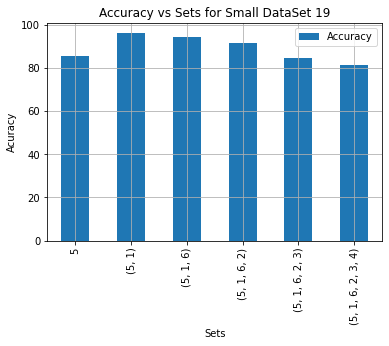

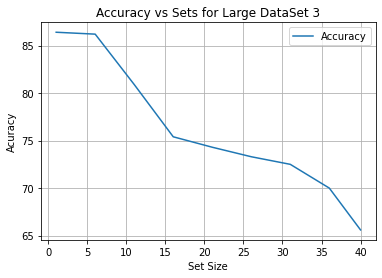

In [143]:


lilDataForward= (forwardSelection(lilData,globalAccs=[], globalFts=[]))
neighbor_df = pd.DataFrame({
   # 'Accuracy':    [0.81,  lilDataForward[2][0],  lilDataForward[2][1] ,   lilDataForward[2][2] ,   lilDataForward[2][3] ,   lilDataForward[2][4],    lilDataForward[2][5] ],
   'Accuracy':    lilDataForward[2] ,
   }, index=      [(5),  (5,1),  (5,1,6),   (5,1,6,2),    (5,1,6,2,3),     (5,1,6,2,3,4,)]
   )
neighborGraph = neighbor_df.plot.bar(title= "Accuracy vs Sets for Small DataSet 19", grid= True)
neighborGraph.set_xlabel("Sets")
neighborGraph.set_ylabel("Acuracy")


bigDataForward= (forwardSelection(bigData,globalAccs=[], globalFts=[]))
print(len(bigDataForward[2]))
print(len(bigDataForward[1]))
neighbor_df2 = pd.DataFrame({
   'Accuracy':[bigDataForward[2][0],  bigDataForward[2][5] ,   bigDataForward[2][10] ,   bigDataForward[2][15] ,   bigDataForward[2][20],    bigDataForward[2][25],   bigDataForward[2][30], bigDataForward[2][35], bigDataForward[2][39]    ] ,
   }, index=  [len(bigDataForward[1][0]),  len(bigDataForward[1][5]),   len(bigDataForward[1][10]),   len(bigDataForward[1][15]),   len(bigDataForward[1][20]),  len(bigDataForward[1][25]), len(bigDataForward[1][30]), len(bigDataForward[1][35]), len(bigDataForward[1][39])    ]
   )
neighborGraph2 = neighbor_df2.plot.line(title= "Accuracy vs Sets for Large DataSet 3", grid= True)
neighborGraph2.set_xlabel("Set Size")
neighborGraph2.set_ylabel("Acuracy")




# bigDataBackward= (bigDataBacklimination(bigData))
# print(len(bigDataBackward[0]))
# print(len(bigDataBackward[1]))
# # neighbor_df2 = pd.DataFrame({
#    'Accuracy':[bigDataForward[2][0],  bigDataForward[2][5] ,   bigDataForward[2][10] ,   bigDataForward[2][15] ,   bigDataForward[2][20],    bigDataForward[2][25],   bigDataForward[2][30], bigDataForward[2][35], bigDataForward[2][39]    ] ,
#    }, index=  [len(bigDataForward[1][0]),  len(bigDataForward[1][5]),   len(bigDataForward[1][10]),   len(bigDataForward[1][15]),   len(bigDataForward[1][20]),  len(bigDataForward[1][25]), len(bigDataForward[1][30]), len(bigDataForward[1][35]), len(bigDataForward[1][39])    ]
#    )
# neighborGraph2 = neighbor_df2.plot.line(title= "Accuracy vs Sets for Large DataSet 3", grid= True)
# neighborGraph2.set_xlabel("Set Size")
# neighborGraph2.set_ylabel("Acuracy")

# Works Cited:


-   https://www.analyticsvidhya.com/blog/2020/02/4-types-of-distance-metrics-in-machine-learning/

-   https://www.geeksforgeeks.org/pandas-groupby-count-occurrences-in-column/
-   https://www.codingem.com/python-how-to-get-all-combinations-of-a-list/
-   https://www.geeksforgeeks.org/running-python-script-on-gpu/
-   https://www.programiz.com/python-programming/methods/set/intersection
-   https://www.youtube.com/watch?v=nh2IGC_kLWw
